# Interferogram generation over Etna with DIAPASON 

## <a name="quicklink">Quick link

* [Objective](#objective)
* [Data](#data)
* [Workflow](#workflow)
* [License](#license)

## <a name="objective">Objective 

This notebook generates an interogram over the Etna with Sentinel-1 SLC data using DIAPASON and publishes the results as a Research Object available in the INGV VRE. 

DIAPASON is an InSAR processing software developed by the French space agency (CNES) and maintained by ALTAMIRA INFORMATION.

## <a name="data">Data

SENTINEL data products are made available systematically and free of charge to all data users including the general public, scientific and commercial users. Radar data will be delivered within an hour of reception for Near Real-Time (NRT) emergency response, within three hours for NRT priority areas and within 24 hours for systematically archived data.

All data products are distributed in the SENTINEL Standard Archive Format for Europe (SAFE) format.

Sentinel-1 data products are available in single polarisation (VV or HH) for Wave mode and dual polarisation (VV+VH or HH+HV) and single polarisation (HH or VV) for SM, IW and EW modes.

Level-1 Single Look Complex (SLC) products consist of focused SAR data geo-referenced using orbit and attitude data from the satellite and provided in zero-Doppler slant-range geometry. The products include a single look in each dimension using the full transmit signal bandwidth and consist of complex samples preserving the phase information.

## <a name="workflow">Workflow

#### Set the parameters

In [1]:
bbox = '14.8434,37.6010,15.1434,37.9010' 

In [2]:
slave_date = '2018-03-15'

In [3]:
lon_min, lat_min, lon_max, lat_max = bbox.split(',')
    
lon_min = float(lon_min)
lat_min = float(lat_min)
lon_max = float(lon_max)
lat_max = float(lat_max)

In [4]:
p1 = '%s %s' % (lon_min,lat_min)
p2 = '%s %s' % (lon_max,lat_min)
p3 = '%s %s' % (lon_max,lat_max)
p4 = '%s %s' % (lon_min,lat_max)

wkt_aoi = 'POLYGON((%s, %s, %s, %s, %s))' % (p1, p2, p3, p4, p1)

#### Import the python packages

In [46]:
import owslib
from owslib.wps import monitorExecution
import uuid
from owslib.wps import WebProcessingService
import sys
import os
sys.path.append('/opt/anaconda/bin/')
import lxml.etree as etree
os.environ["TMPDIR"] = '1'
os.environ["_CIOP_APPLICATION_PATH"] = '1'
import requests
import cioppy
ciop = cioppy.Cioppy()
import shapely
import dateutil.parser
from shapely.wkt import loads 
import pandas as pd
import geopandas as gp
from datetime import datetime, timedelta
from io import BytesIO
from zipfile import ZipFile
%matplotlib inline
import matplotlib.pyplot as plt
import gdal
import numpy as np
import urlparse

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Define a simple inteferometric search function 

In [6]:
def interferometric_search(slave, aoi, delta = 6):
    
    s1_osd = 'https://catalog.terradue.com/sentinel1/description'
    
    slave_search_params = dict([('uid', slave)])
    
    slave_search = ciop.search(end_point=s1_osd,
                         params=slave_search_params,
                         output_fields='identifier,productType,track,startdate,enddate,wkt',
                         model='EOP')
    
    master_search_params = dict([('geom', slave_search[0]['wkt']),
                           ('track', slave_search[0]['track']),
                            ('pt',slave_search[0]['productType']),
                            ('start', (dateutil.parser.parse(slave_search[0]['startdate']) - timedelta(days=delta +1)).isoformat()),
                            ('stop', (dateutil.parser.parse(slave_search[0]['enddate']) - timedelta(days=delta -1)).isoformat())])
    
    try:
        master_search = ciop.search(end_point=s1_osd, 
                            params=master_search_params,
                            output_fields='identifier,wkt,self',
                            model='EOP')
    except IndexError:
        return None
    
    slave_wkt = loads(slave_search[0]['wkt'])
    aoi = loads(aoi)

    result = []

    for index, elem in enumerate(master_search):
        
        master_search[index]['slave'] = slave
        master_search[index]['slave_wkt'] = slave_wkt
        master_wkt = loads(elem['wkt'])
        intersec=slave_wkt.intersection(master_wkt)
        master_search[index]['slave_master_intersec'] = (intersec.area/slave_wkt.area) * 100
        master_search[index]['slave_master_intersec_wkt'] = intersec
        
    
        if intersec.contains(aoi) or intersec.intersects(aoi):
            intersec_aoi = intersec.intersection(aoi)
            master_search[index]['aoi_intersec'] = (aoi.area/intersec_aoi.area) * 100
            master_search[index]['aoi_intersec_wkt'] = intersec_aoi
        else: 
            master_search[index]['aoi_intersec'] = -1
            master_search[index]['aoi_intersec_wkt'] = ''
    
        result.append({'master' : master_search[index]['identifier'],
                       'master_ref' : master_search[index]['self'],
                       'master_wkt': master_wkt,
                       'slave': slave,
                       'slave_wkt': slave_wkt,
                       'master_slave_intersec': slave_wkt,
                       'master_slave_intersec' : master_search[index]['slave_master_intersec'],
                       'slave_master_intersec_wkt' : master_search[index]['slave_master_intersec_wkt'],
                       'aoi_intersec': master_search[index]['aoi_intersec'],
                       'aoi_intersec_wkt': master_search[index]['aoi_intersec_wkt']})
        
    return gp.GeoDataFrame(result)

#### Identify the Sentinel-1 slave product according to the area of interest and time of interest

In [7]:
s1_osd = 'https://catalog.terradue.com/sentinel1/description'

In [8]:
slave_search_params = dict([('bbox', bbox),
                            ('pt', 'SLC'),
                            ('start', slave_date),
                            ('stop', slave_date)])

In [9]:
slave_search = ciop.search(end_point=s1_osd, 
                            params=slave_search_params,
                            output_fields='identifier,wkt,self',
                            model='EOP')

In [10]:
slave = slave_search[0]['self']

The Sentinel-1 slave is:

In [11]:
slave

'https://catalog.terradue.com/sentinel1/search?format=atom&uid=S1B_IW_SLC__1SDV_20180315T165540_20180315T165607_010045_012376_E198'

#### Search for the master candidates according to the slave identified above

In [12]:
interf = interferometric_search(slave_search[0]['identifier'],
                      wkt_aoi,
                      12)

List the master candidates

In [13]:
interf

aoi_intersec                                   aoi_intersec_wkt  \
0     -1.000000                                                      
1    132.506239  POLYGON ((15.1434 37.69555696421482, 14.8434 3...   
2    224.267231  POLYGON ((15.1434 37.69521291604379, 14.8434 3...   

                                              master  \
0  S1B_IW_SLC__1SDV_20180303T165604_20180303T1656...   
1  S1B_IW_SLC__1SDV_20180303T165540_20180303T1656...   
2  S1B_IW_SLC__1SDV_20180303T165515_20180303T1655...   

                                          master_ref  master_slave_intersec  \
0  https://catalog.terradue.com/sentinel1/search?...               8.046119   
1  https://catalog.terradue.com/sentinel1/search?...              99.932145   
2  https://catalog.terradue.com/sentinel1/search?...               7.900001   

                                          master_wkt  \
0  POLYGON ((13.194742 40.705025, 16.242071 41.10...   
1  POLYGON ((13.588897 39.155212, 16.56493 39.560...   
2  POLYGON ((13.962564 37.664299, 16.873503 38.07...   

                                               slave  \
0  S1B_IW_SLC__1SDV_20180315T165540_20180315T1656...   
1  S1B_IW_SLC__1SDV_20180315T165540_20180315T1656...   
2  S1B_IW_SLC__1SDV_20180315T165540_20180315T1656...   

                           slave_master_intersec_wkt  \
0  POLYGON ((13.589498 39.155727, 16.564466919808...   
1  POLYGON ((13.99111773803676 37.53453398839396,...   
2  POLYGON ((16.87178194724067 38.06991204498015,...   

                                           slave_wkt  
0  POLYGON ((13.589498 39.155727, 16.565506 39.56...  
1  POLYGON ((13.589498 39.155727, 16.565506 39.56...  
2  POLYGON ((13.589498 39.155727, 16.565506 39.56...

Select the master that covers the most the slave

In [14]:
index = interf['master_slave_intersec'].idxmax()

In [15]:
gp.GeoDataFrame(interf.iloc[index])

1
aoi_intersec                                                         132.506
aoi_intersec_wkt           POLYGON ((15.1434 37.69555696421482, 14.8434 3...
master                     S1B_IW_SLC__1SDV_20180303T165540_20180303T1656...
master_ref                 https://catalog.terradue.com/sentinel1/search?...
master_slave_intersec                                                99.9321
master_wkt                 POLYGON ((13.588897 39.155212, 16.56493 39.560...
slave                      S1B_IW_SLC__1SDV_20180315T165540_20180315T1656...
slave_master_intersec_wkt  POLYGON ((13.99111773803676 37.53453398839396,...
slave_wkt                  POLYGON ((13.589498 39.155727, 16.565506 39.56...

In [16]:
master = interf['master_ref'].iloc[index]

The master is:

In [17]:
master

'https://catalog.terradue.com/sentinel1/search?format=atom&uid=S1B_IW_SLC__1SDV_20180303T165540_20180303T165607_009870_011DAB_93B1'

#### Plot the slave/master and AOI

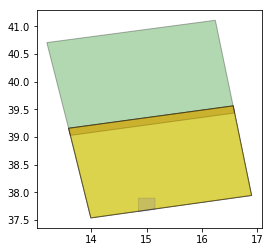

In [18]:
selected = gp.GeoDataFrame(interf.iloc[:index+1])

fig, ax = plt.subplots()
ax.set_aspect('equal')

selected = selected.set_geometry('master_wkt')
selected.plot(ax=ax, color='green', edgecolor='black', alpha=0.3)

selected = selected.set_geometry('slave_wkt')
selected.plot(ax=ax, color='yellow', edgecolor='black', alpha=0.3)

selected = selected.set_geometry('slave_master_intersec_wkt')
selected.plot(ax=ax, color='red', edgecolor='black', alpha=0.1)

selected = selected.set_geometry('aoi_intersec_wkt')
selected.plot(ax=ax, color='blue', edgecolor='black', alpha=0.1)

plt.show();

#### Prepare the processing request

In [19]:
wps_url = 'https://geohazards-tep-marketplace.terradue.com/zoo-bin/zoo_loader.cgi'

In [20]:
wps = WebProcessingService(wps_url, verbose=False, skip_caps=True)

In [21]:
wps.getcapabilities()

List the processing services available

In [22]:
for index, elem in enumerate(wps.processes):
    print(index, elem.identifier)

(0, 'geohazards_tep_dsm_opt_workflow_1_1')
(1, 'geohazards_tep_dcs_rss_fullres_full_res_multi_mission_data_browser_1_5_1')
(2, 'geohazards_tep_dcs_insar_diapason_s1_dcs_diapason_s1_1_1')
(3, 'geohazards_tep_dcs_rss_snap_s1_insar_snap_s1_ifg_overall_1_2')
(4, 'geohazards_tep_dcs_rss_band_combination_band_combination_1_1')
(5, 'geohazards_tep_dcs_rss_snap_s1_coin_snap_s1_coh_sigma_1_4_1')
(6, 'geohazards_tep_dcs_rss_fullres_full_res_multi_mission_data_browser_1_8_0')
(7, 'geohazards_tep_dcs_fastvel_wf_fastvel_1_4_2')
(8, 'geohazards_tep_dcs_rss_snap_s1_insar_snap_s1_ifg_overall_1_4')
(9, 'geohazards_tep_mpic_opt_dcs_mpic_opt_1_2_4')
(10, 'geohazards_tep_dcs_rss_fullres_full_res_multi_mission_data_browser_1_2_2')
(11, 'geohazards_tep_dcs_rss_band_combination_band_combination_1_3_2')
(12, 'geohazards_tep_mpic_opt_dcs_mpic_opt_1_2_3')
(13, 'geohazards_tep_dcs_rss_snap_s1_coin_snap_s1_coh_sigma_1_4_3')
(14, 'geohazards_tep_dcs_stemp_s2_dcs_stemp_s2_1_0_2')
(15, 'geohazards_tep_dcs_rss_fullre

In [23]:
process_id = 'geohazards_tep_dcs_insar_diapason_s1_dcs_diapason_s1_1_1_1'

In [24]:
process = wps.describeprocess(process_id)

In [25]:
process.title

'DIAPASON InSAR Sentinel-1 TOPSAR(IW,EW)'

In [26]:
process.abstract

'DIAPASON is an InSAR tool suite developed by the French Space Agency (CNES) and maintained by ALTAMIRA INFORMATION.This service performs an InSAR workflow on Sentinel-1 TOPSAR (IW,EW) data, producing interferograms, amplitude and coherence maps.To run this service , specify master and slave Sentinel-1 SLC images.'

#### List the WPS service input parameters and build the request

In [27]:
for input in process.dataInputs:
    print(input.identifier)

master
pol
slave
aoi
psfiltx
unwrap
_T2Username


In [28]:
master

'https://catalog.terradue.com/sentinel1/search?format=atom&uid=S1B_IW_SLC__1SDV_20180303T165540_20180303T165607_009870_011DAB_93B1'

In [29]:
slave

'https://catalog.terradue.com/sentinel1/search?format=atom&uid=S1B_IW_SLC__1SDV_20180315T165540_20180315T165607_010045_012376_E198'

In [30]:
polarization = 'VV'
psfiltx = 0.5
unwrap = 'false'

In [31]:
inputs = [('master', master),
        ('slave', slave),
        ('pol', polarization),
        ('aoi', bbox),
        ('psfiltx', str(psfiltx)),
        ('unwrap', unwrap),
        ('_T2Username', 'fbrito')]

#### Invoke the processing service and wait for its conclusion

In [32]:
wps = WebProcessingService(wps_url, verbose=False, skip_caps=True)

In [33]:
execution = owslib.wps.WPSExecution(url=wps.url)

In [34]:
execution_request = execution.buildRequest(process_id, 
                                           inputs, 
                                           output = [('result_osd', False)])

In [35]:
execution_response = execution.submitRequest(etree.tostring(execution_request))

In [36]:
execution.parseResponse(execution_response)

In [37]:
execution.statusLocation

'http://geohazards-tep-marketplace.terradue.com/zoo-bin/zoo_loader.cgi?request=Execute&service=WPS&version=1.0.0&Identifier=GetStatus&DataInputs=sid=f3111292-4216-11e8-b57f-0242ac110009&RawDataOutput=Result'

In [38]:
monitorExecution(execution)

In [39]:
execution.isSucceded()

True

#### List the results

In [40]:
for output in execution.processOutputs:
    print(output.identifier)

result_osd
QUOTATION


In [41]:
results_osd = execution.processOutputs[0].reference
results_osd

'https://recast.terradue.com/t2api/describe/fbrito/_results/workflows/geohazards_tep_dcs_insar_diapason_s1_dcs_diapason_s1_1_1_1/run/f3111292-4216-11e8-b57f-0242ac110009/0003188-171122163343932-oozie-oozi-W'

In [43]:
search = ciop.search(end_point=results_osd,
                         params=[],
                         output_fields='identifier,enclosure',
                         model='GeoTime')

#### Update the results references to use the Data Access security token of the generated results

In [49]:
access_token = 'eyJ2ZXIiOiIyIiwidHlwIjoiSldUIiwiYWxnIjoiUlMyNTYiLCJraWQiOiJRdldZU0xtOGxiUzBmUUdaN1hrSktROXo3a3BPM1k2UU93cE5sNmkxc25vIn0.eyJzdWIiOiJqZnJ0QDAxYzlnbW5uM3MxcDRmMHBrMHA0eDkwZXkxXC91c2Vyc1wvZmJyaXRvIiwic2NwIjoibWVtYmVyLW9mLWdyb3Vwczpub2EtcmFkYXJzYXQyLndyaXRlcixvd3MxMy1lb2Mud3JpdGVyLGVjLW5leHRnZW9zcy5yZWFkZXIsY3JsLXJhZGFyc2F0Mi5yZWFkZXIsZWMtZWNvcG90ZW50aWFsLnJlYWRlcixub2EtY29zbW9za3ltZWQud3JpdGVyLG5vYS1lcnMud3JpdGVyLGNybC1jb3Ntb3NreW1lZC53cml0ZXIsZW52aXNhdC53cml0ZXIsb3dzMTMtZW9jLnJlYWRlcixIYWl0aVJPLXRzeC5yZWFkZXIsc3BvdC03LnJlYWRlcixzcG90LTYucmVhZGVyLG5vYS10ZXJyYXNhci14LndyaXRlcixlbGxpcC1oYXJ2ZXN0aW5nLnJlYWRlcixub2EtdGVycmFzYXIteC5yZWFkZXIsZS1sZWFybmluZy53cml0ZXIsZWMtYmV0dGVyLnJlYWRlcixzcG90LTcud3JpdGVyLGVvLXNhbXBsZXMud3JpdGVyLG5vYS1lcnMucmVhZGVyLHNwb3QtNi53cml0ZXIsc3RhZmYsZWxsaXAtY2FjaGluZy5yZWFkZXIsZWMtZXZlcmVzdC5yZWFkZXIsY2FjaGUud3JpdGVycyxjcmwtcmFkYXJzYXQyLndyaXRlcixyZWFkZXJzLG5vYS1yYWRhcnNhdDIucmVhZGVyLGNhY2hlLnJlYWRlcnMsZmJyaXRvLm93bmVyLG5vYS1jb3Ntb3NreW1lZC5yZWFkZXIsY3JsLWNvc21vc2t5bWVkLnJlYWRlciBhcGk6KiIsImF1ZCI6ImpmcnRAMDFjOWdtbm4zczFwNGYwcGswcDR4OTBleTEiLCJpc3MiOiJqZnJ0QDAxYzlnbW5uM3MxcDRmMHBrMHA0eDkwZXkxIiwiZXhwIjoxNTIzOTYwNTI5LCJpYXQiOjE1MjM5NTY5MjksImp0aSI6ImQzNzliN2E4LTQzNDMtNDFmZi05ZTVmLTQ2NzIxMmM2NjMxYSJ9.N5xH6H6FI7Jq-00slLAxW9doBrkekwMCl8WJaqioEg2IvYC7c1B8uYOaU1b10g0uIokRE9R-gKUMuvteB0TxLEKwKY_bCbFoqR1d5ePZxUqNNq07kYJ28JVD6yeZ490hwiOAtvHCR0n-fh7qCMVLc2YpIuTTx7cw4M0-mZIpLtinDHSfqwIHQ3IAQWTUTdOyoQDwRVEO6JyBzkTWPnXZiU23Qe_blFSMDINZ-mcQRHYaxbkRAocq7gGXquAozCyPsGbhe_aMogVLV3LZUVLuSVBp0J-B9UAWMZe06ainHdP4O1lsCKp6thK2c40LlY_oMxUQstCjJ1EBqpv-V5Pezg'

In [50]:
import shutil

for index, elem in enumerate(search):
   
    resource = '%s://%s:%s@%s/api%s' % (urlparse.urlparse(elem['enclosure']).scheme,
                                      'fbrito', 
                                      access_token, 
                                      urlparse.urlparse(elem['enclosure']).hostname,
                                      urlparse.urlparse(elem['enclosure']).path)
    search[index]['api'] = '/vsicurl/%s' % resource
   
    search[index]['local_path'] = os.path.join(os.getcwd(), os.path.basename(urlparse.urlparse(resource).path))
    response = requests.get(resource, stream=True)
    with open(search[index]['local_path'], 'wb') as out_file:
        shutil.copyfileobj(response.raw, out_file)
 
    print search[index]['local_path']

/workspace/ever-est-catania/amp_9870_10045_ortho.tiff
/workspace/ever-est-catania/coh_9870_10045_ortho.tiff
/workspace/ever-est-catania/pha_9870_10045_ortho.tiff
/workspace/ever-est-catania/logs.zip


#### Plot the results

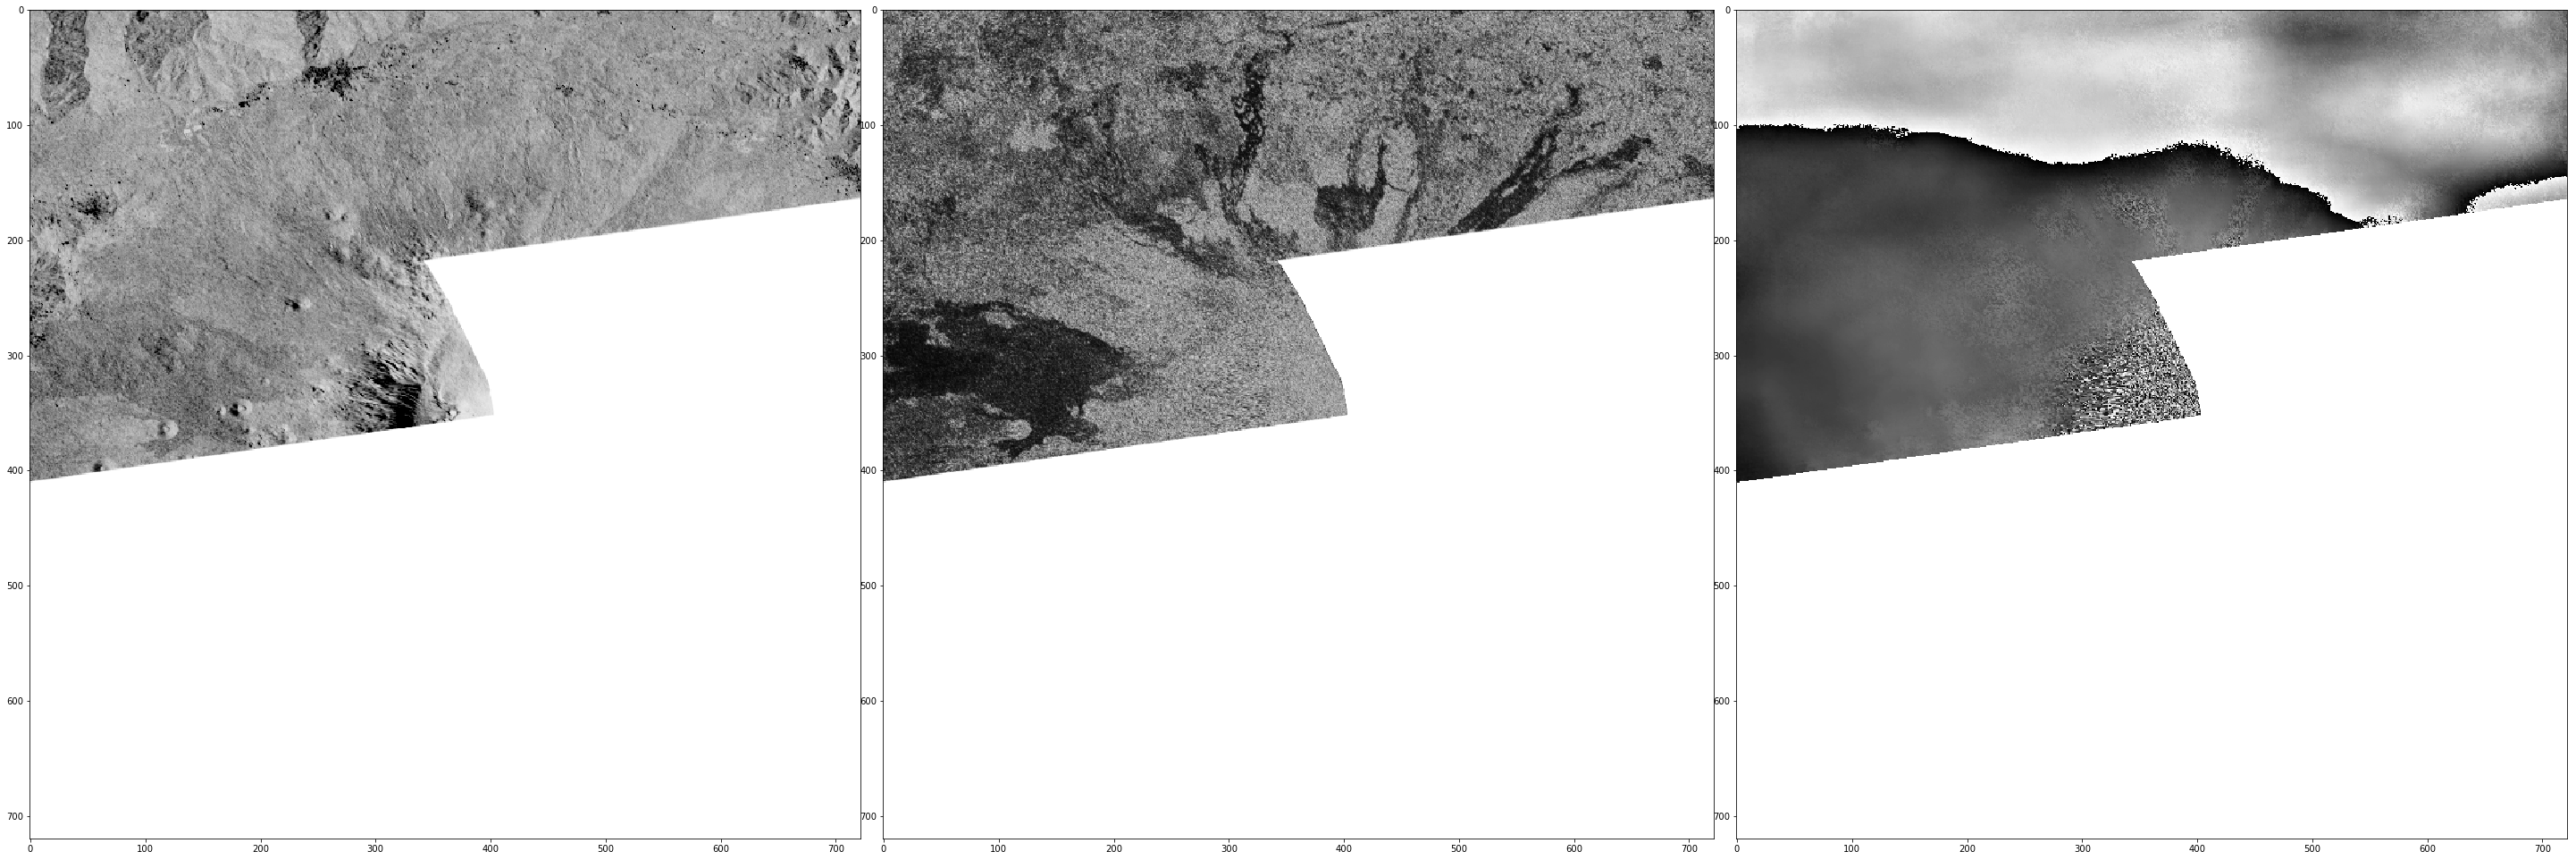

In [51]:
fig = plt.figure(figsize=(40,40))
i = 1

for index, elem in enumerate(search):
    if index == 3: 
        continue

    ds = gdal.Open(elem['api'])
    
    a=fig.add_subplot(330+i)
    imgplot = plt.imshow (ds.ReadAsArray(0, 0, 722, 720).astype(np.float32) , cmap=plt.cm.binary, vmin=0, vmax = 255)
    i = i+1
    

plt.tight_layout()
fig = plt.gcf()
plt.show()

fig.clf()
plt.close()

#### Create a research object

In [64]:
ro_title = 'Interferogram over the Etna generated with DIAPASON'
ro_description = 'This is the result of DIAPASON Service invoked via Jupyter'
ro_vrc = 'INGV'
master = master
slave = slave

In [65]:
sys.path.append(os.getcwd())
import ro4eo

In [66]:
roeo = ro4eo.EOResearchObject(access_token='21dc9abb-30c6-36b1-a2db-2770922f8058',
                       title=ro_title,
                       description=ro_description,
                       vrc=ro_vrc,
                       aoi=wkt_aoi)

In [67]:
roeo.isTokenValid()

True

In [68]:
roeo.add_resource(master)
roeo.add_resource(slave)

In [69]:
for index, elem in enumerate(search):
    a= elem['local_path']
    roeo.add_result(a)

In [70]:
ro = roeo.publish()

ConnectionError: Expected status code 201, but got 409

In [ ]:
ro

## <a name="license">License

This work is licenced under a [Attribution-ShareAlike 4.0 International License (CC BY-SA 4.0)](http://creativecommons.org/licenses/by-sa/4.0/) 

YOU ARE FREE TO:

* Share - copy and redistribute the material in any medium or format.
* Adapt - remix, transform, and built upon the material for any purpose, even commercially.

UNDER THE FOLLOWING TERMS:

* Attribution - You must give appropriate credit, provide a link to the license, and indicate if changes were made. You may do so in any reasonable manner, but not in any way that suggests the licensor endorses you or your use.
* ShareAlike - If you remix, transform, or build upon the material, you must distribute your contributions under the same license as the original.